In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from comet_ml import Experiment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import re
import auth


%matplotlib inline

In [2]:
# Import MoMA dataset

df = pd.read_csv('data/data-1589133901203-moma-artwork-data.csv')

## Splitting the Design Category

In [3]:
df_design_only = df[df['Classification'] == 'Design']

In [4]:
def classify_design_object(x):
    
    # Manual segregation by picking out key words in the title
    
    category_list = {
                     'decorative_object':  ['vase', 'dish', 'tumblers', 'bowl','desk fan'
                                            , 'table fan', 'flatware', 'dinnerwear','pitcher'
                                            , 'goblet', 'lamp', 'plate', 'clock', 'wall']
                     ,'furniture': ['table', 'chair', 'rocker', 'stool']
                     ,'poster': ['poster']
                    }

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for cat, keywords in category_list.items():
        for x in keywords:
            if list_words_cleaned.find(x) != -1:
                return cat
            
    # Manual segregation by picking out key words in the medium
            
    category_list_medium = {
                     'poster': ['lithograph', 'poster', 'on paper']
                    }
    
    for cat, keywords in category_list_medium.items():
        for x in keywords:
            if list_words_cleaned.find(x) != -1:
                return cat
    return ''

In [5]:
# Categorize Design Objects by title

df_design_only = df[df['Classification'] == 'Design']

df_design_only['new_cat_title'] = df_design_only['Title'].apply(lambda x: classify_design_object(x))
df_design_only['new_cat_medium'] = df_design_only['Medium'].apply(lambda x: classify_design_object(x))

<ipython-input-5-4b4b4825362f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design_only['new_cat_title'] = df_design_only['Title'].apply(lambda x: classify_design_object(x))
<ipython-input-5-4b4b4825362f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design_only['new_cat_medium'] = df_design_only['Medium'].apply(lambda x: classify_design_object(x))


In [6]:
df_design_only['combined_cat'] = df_design_only['new_cat_title'] + df_design_only['new_cat_medium']

<ipython-input-6-e2da04e313b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design_only['combined_cat'] = df_design_only['new_cat_title'] + df_design_only['new_cat_medium']


In [7]:
def design_category(x):
    category_mapping = {
                        'poster' : 'poster'
                        ,'decorative_object': 'decorative_object'
                        ,'furniture': 'furniture'
                        ,'posterposter': 'poster'
                        ,'furnituredecorative_object': 'furniture'
                        ,'decorative_objectdecorative_object' : 'decorative_object'
                        ,'decorative_objectposter': 'poster'
                        ,'furnitureposter' : 'poster'
                        ,'furniturefurniture' : 'furniture'
                        ,'posterdecorative_object' : 'poster'}
    
    try: 
        return category_mapping[str(x)]
    except:
        return 'other'

In [8]:
df_design_only['Classification'] = df_design_only['combined_cat'].apply(lambda x: design_category(x))

<ipython-input-8-fadd7549606a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design_only['Classification'] = df_design_only['combined_cat'].apply(lambda x: design_category(x))


In [9]:
# Merge Dataset with everything else

df_non_design = df[df['Classification'] != 'Design']

# Reduce to original column only
df_design_only = df_design_only[df.columns]

In [10]:
df_new = pd.concat([df_non_design, df_design_only ])

In [11]:
df_new['Classification'].unique()

array(['Architecture', 'Audio', 'Mies van der Rohe Archive',
       'Illustrated Book', 'Print', 'Drawing', 'Periodical', 'Multiple',
       'Photograph', 'Painting', 'Ephemera', 'Architectural Model',
       'Video', 'Performance', 'Software', 'Sculpture', 'Installation',
       'Film', 'Textile', '(not assigned)', 'Collage', 'Graphic Design',
       'Frank Lloyd Wright Archive', 'Media', 'Work on Paper', 'Poster',
       'other', 'decorative_object', 'furniture', 'poster'], dtype=object)

In [12]:
# Reduce to only use data with labels in scope

labels_in_scope = ['Print', 'Drawing', 'Photograph', 'Painting',
                   'Sculpture', 'Installation','decorative_object', 'furniture']

df_classifier_dataset = df_new[df_new['Classification'].isin(labels_in_scope)]

In [13]:
df_classifier_dataset['Classification'].unique()

array(['Print', 'Drawing', 'Photograph', 'Painting', 'Sculpture',
       'Installation', 'decorative_object', 'furniture'], dtype=object)

## Check Classification Class Imbalance

In [14]:
df_cat = df_classifier_dataset[['index', 'Classification']].groupby('Classification').count().sort_values('index', ascending=False)

In [15]:
# calculate proportion of art records in each category

df_cat['perc_proportion'] = round(df_cat['index']/ df.shape[0], 2)*100

In [16]:
df_cat

,index,perc_proportion
Classification,,
Print,20039,29.0
Photograph,15890,23.0
Drawing,9525,14.0
Painting,2102,3.0
Sculpture,1266,2.0
decorative_object,811,1.0
furniture,504,1.0
Installation,336,0.0


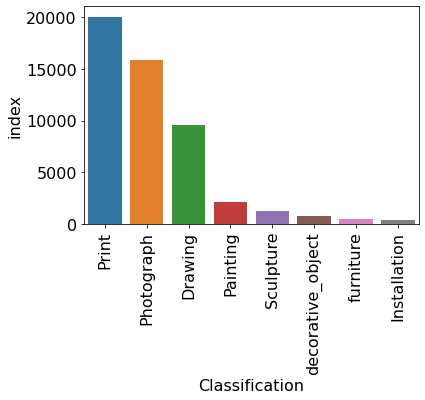

In [17]:
# Plot top 20 Classifications

plt.rcParams.update({'font.size': 16})
sns.barplot(x=df_cat.index[:20], 
            y=df_cat['index'][:20])
plt.xticks(rotation='vertical')

plt.show()

## Downsampling high count Categories

Since this is a simplistic keyword model, we'll balance the classes by downsampling to 750 records for anything over 750 count to use as the train, test and validation.

In [18]:
#initialize new dataframe
df_balanced_dataset = pd.DataFrame(columns=df_classifier_dataset.columns)

for clas in df_classifier_dataset['Classification'].unique():
    sub_df = df_classifier_dataset[df_classifier_dataset['Classification'] == clas]
    if sub_df.shape[0] > 750:
        sub_df_ds = sub_df.sample(750, random_state=888)
        df_balanced_dataset = pd.concat([df_balanced_dataset,sub_df_ds]) 
    else:
        df_balanced_dataset = pd.concat([df_balanced_dataset,sub_df]) 

In [19]:
df_cat = df_balanced_dataset[['index', 'Classification']].groupby('Classification').count().sort_values('index', ascending=False)

In [20]:
df_cat

,index
Classification,
Drawing,750
Painting,750
Photograph,750
Print,750
Sculpture,750
decorative_object,750
furniture,504
Installation,336


# Build Features

### Engineered Features:

1. **has_3dimension()**
based on 'dimensions' (size) column
useful to seperate into two categories (helpful for):
    * instalations
    * sculpture
    * decorative objects
    * furniture


2. **X_keywords()**
based on 'medium' column, unique and helpful for each class (note: sclpture does not have it's own keyword since its so similar to installation)


3. **is_drawing()**
based on drawing_keywords() and  drawing_paper_words() it can be either or and both, feature to help with the tree.

4. **long_list_of_things()**
The idea behind this is if the medium is a list with 5 or more items or longer than 120 characters in length, it's complicated and likely to be an installation rather than a sculpture


In [21]:
# Check how many have a depth (parsing Dimensions column)

def has_3dimensions(x):
    string = str(x).replace(" ", "").replace(".", "").replace("/", "").replace("'", "").lower()
    try:
        re.search(r'\d+x\d+x\d+', string).group()
        return True
    except AttributeError:
        for term in ['dia', 'high', 'tall', 'long']:
            s = string.find(term)
            if s != -1:
                return True
    return False

In [22]:
def painting_keyword(x):
    
    # Manual segregation by picking out key words in the title
    
    painting_word_list = ['on canvas'
                      , 'on wood'
                      , 'oil on'
                      , 'acrylic'
                      , 'tempera'
                      , 'gouache'
                      , ' board'
                      , 'painted'
                      , 'watercolo'
                      , 'mixed media'
                      , 'collage']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in painting_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False

In [23]:
def photo_keyword(x):
    
    # Manual segregation by picking out key words in the title
    
    photo_word_list = ['silver print'
                         , 'gelatin print'
                         , 'gelatin silver'
                         , 'selenium tone'
                         , 'platinum print'
                         , 'negative'
                         , 'instant print'
                         , 'polaroid'
                         , 'cibachrome'
                         , 'chromogenic'
                         ,  'photo'
                         , 'inkjet print'
                         , 'vibrachrome'
                         , 'selenium tone']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in photo_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False


In [24]:
def drawing_keyword(x):
    
    # Manual segregation by picking out key words in the medium
    
    drawing_word_list = ['pencil'
                         , 'charcoal'
                         , 'ink'
                         , 'pen'
                         , 'crayon'
                         , 'pastel'
                         , 'chalk'
                         , 'carbon paper transfer'
                         , 'graphite']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in drawing_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False

In [25]:
def drawing_paper_word(x):
    
    # Manual segregation by picking out key words in the medium
    
    drawing_paper_word_list = ['on paper', 'colored paper', 'graph paper']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in drawing_paper_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False

In [26]:
def is_drawing(df):
    df['is_drawing'] = df['drawing_keyword'] + df['drawing_paper_word']
    df['is_drawing'] = df['is_drawing'].apply(lambda x: False if x == False else True)
    return df

In [27]:
def print_keyword(x):
    
    # Manual segregation by picking out key words in the medium
    
    print_word_list = ['lithograp'
                         , 'etching'
                         , 'letterpress'
                         , 'screenprint'
                         , 'woodcut'
                         , 'reproduction'
                         , 'aquatint'
                         , 'drypoint'
                         , 'blueprint'
                         , 'pochoir'
                         , 'intaglio'
                         , 'engraving'
                         , 'carborundum print'
                         , 'mezzotints'
                         , 'diazotype'
                         , 'photocopy'
                         , 'linoleum'
                         , 'linocut'
                         , 'emboss'
                         , 'monotype']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in print_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False


In [28]:
def installation_keyword(x):
    
    # Manual segregation by picking out key words in the medium
    
    install_word_list = ['installation'
                         , 'on wall'
                         , 'audio'
                         , 'TV' 
                         , 'projector'
                         , 'projection screen'
                         , 'sound system'
                         , 'video'
                         , 'computer'
                         , 'pneumatic'
                         , 'display case'
                         , 'helium'
                         , ' parts'
                         , 'lamp'
                         , 'light'
                         , 'wire']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in install_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False

In [29]:
def furniture_keyword(x):
    
    # Manual segregation by picking out key words in the medium
    
    furniture_word_list = ['table', 'chair', 'rocker', 'stool']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in furniture_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False


def decorative_obj_keyword(x):
    
    # Manual segregation by picking out key words in the medium
    
    dec_obj_word_list = ['vase', 'dish', 'tumblers', 'bowl','desk fan'
                                            , 'table fan', 'flatware', 'dinnerwear','pitcher'
                                            , 'goblet', 'lamp', 'plate', 'clock', 'wall']

    list_words_cleaned = re.sub(r'\W+', ' ', str(x).lower())

    for x in dec_obj_word_list:
            if list_words_cleaned.find(x) != -1:
                return True
            
    return False

In [30]:
def long_list_of_things(x):
    if len(re.findall(',', x)) >= 4:
        return True
    elif len(x) > 120:
        return True
    else:
        return False

In [31]:
df.columns

Index(['index', 'Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference_cm', 'Depth_cm', 'Diameter_cm', 'Height_cm', 'Length_cm',
       'Weight_kg', 'Width_cm', 'SeatHeight_cm', 'Duration_sec', 'updated_at'],
      dtype='object')

In [32]:
def area(df):
    df['area'] = df['Height_cm']*df['Width_cm']
    df['area'] = df['area'].apply(lambda x: x if x > 1 else 0)
    return df

## Compute the Features

In [33]:

# Add features based on Medium description
for feature, func in { 'long_list_of_things' : lambda x: long_list_of_things(str(x))
                      ,'installation_keyword' : lambda x: installation_keyword(str(x))
                      ,'print_keyword' : lambda x: print_keyword(str(x))
                      ,'drawing_paper_word' : lambda x: drawing_paper_word(str(x))
                      ,'drawing_keyword' : lambda x: drawing_keyword(str(x))
                      ,'painting_keyword' : lambda x: painting_keyword(str(x))
                      ,'photo_keyword' : lambda x: photo_keyword(str(x))
                      
                          }.items():
    
    df_balanced_dataset[feature] = df_balanced_dataset['Medium'].apply(func)
    
# Add features based on dimensions
df_balanced_dataset['has_3dimensions'] = df_balanced_dataset['Dimensions'].apply(lambda x: has_3dimensions(str(x)))

# Add features based on title/description
for feature, func in {'furniture_keyword' : lambda x: furniture_keyword(str(x))
                      ,'decorative_obj_keyword' : lambda x: decorative_obj_keyword(str(x))
                     }.items():
    df_balanced_dataset[feature] = df_balanced_dataset['Title'].apply(func)
    
# Add area
df_balanced_dataset_vol = area(df_balanced_dataset)

# Add is_drawing
df_balanced_dataset_final =  is_drawing(df_balanced_dataset_vol)

/Users/katielazell-fairman/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [34]:
df_balanced_dataset_final[df_balanced_dataset_final['area'] > 0]

,index,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,...,print_keyword,drawing_paper_word,drawing_keyword,painting_keyword,photo_keyword,has_3dimensions,furniture_keyword,decorative_obj_keyword,area,is_drawing
30139,67648,Catullus from the portfolio Six Latin Writers ...,Cy Twombly,5988,"(American, 1928–2011)",American,1928,2011,Male,1975-1976,...,True,False,False,False,False,False,False,False,838.200000,False
43356,87448,Lips from To Kiss Your Lips,Julia Jacquette,8121,"(American, born 1964)",American,1964,0,Female,1999,...,True,False,False,False,False,False,False,False,761.760000,False
31566,70170,Cockatoo AAA Dracula,Billy Al Bengston,472,"(American, born 1934)",American,1934,0,Male,1968,...,True,False,False,False,False,False,False,False,766.800000,False
25667,60790,Star I,Yamaguchi Gen,6481,"(Japanese, 1896–1976)",Japanese,1896,1976,Male,1963,...,True,False,False,False,False,False,False,False,1607.200000,False
32220,71552,Third Class (Terceira classe) from the series ...,Lasar Segall,5317,"(Brazilian, 1889 - 1957)",Brazilian,1889,1957,Male,1928,...,True,False,False,False,False,False,False,False,894.240000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66621,129773,Feltri Chair,Gaetano Pesce,4570,"(Italian, born 1939)",Italian,1939,0,Male,1986,...,False,False,False,False,False,True,True,False,17826.758257,False
66693,130290,Low chair,Charlotte Perriand,4564,"(French, 1903–1999)",French,1903,1999,Female,designed 1940; manufactured 1946,...,False,False,False,False,False,False,True,False,4458.879885,False
67620,132236,REX Lounge Chairs,Niko Kralj,50084,(1920–2013),Slovenian,1920,2013,Male,1956,...,False,False,False,False,False,False,True,False,522.000000,False
68785,137448,Armchair (model 45),Finn Juhl,2949,"(Danish, 1912–1989)",Danish,1912,1989,Male,1945,...,False,False,False,False,False,True,True,False,4916.139457,False


In [35]:
cols_to_use = ['long_list_of_things'
        , 'installation_keyword'
        , 'print_keyword'
        , 'drawing_paper_word'
        , 'drawing_keyword'
        , 'painting_keyword'
        , 'photo_keyword'
        , 'has_3dimensions'
        , 'furniture_keyword'
        , 'decorative_obj_keyword'
        , 'is_drawing'
#         , 'area'
              ]

[Text(0.5, 0, 'long_list_of_things'),
 Text(1.5, 0, 'installation_keyword'),
 Text(2.5, 0, 'print_keyword'),
 Text(3.5, 0, 'drawing_paper_word'),
 Text(4.5, 0, 'drawing_keyword'),
 Text(5.5, 0, 'painting_keyword'),
 Text(6.5, 0, 'photo_keyword'),
 Text(7.5, 0, 'has_3dimensions'),
 Text(8.5, 0, 'furniture_keyword'),
 Text(9.5, 0, 'decorative_obj_keyword'),
 Text(10.5, 0, 'is_drawing')]

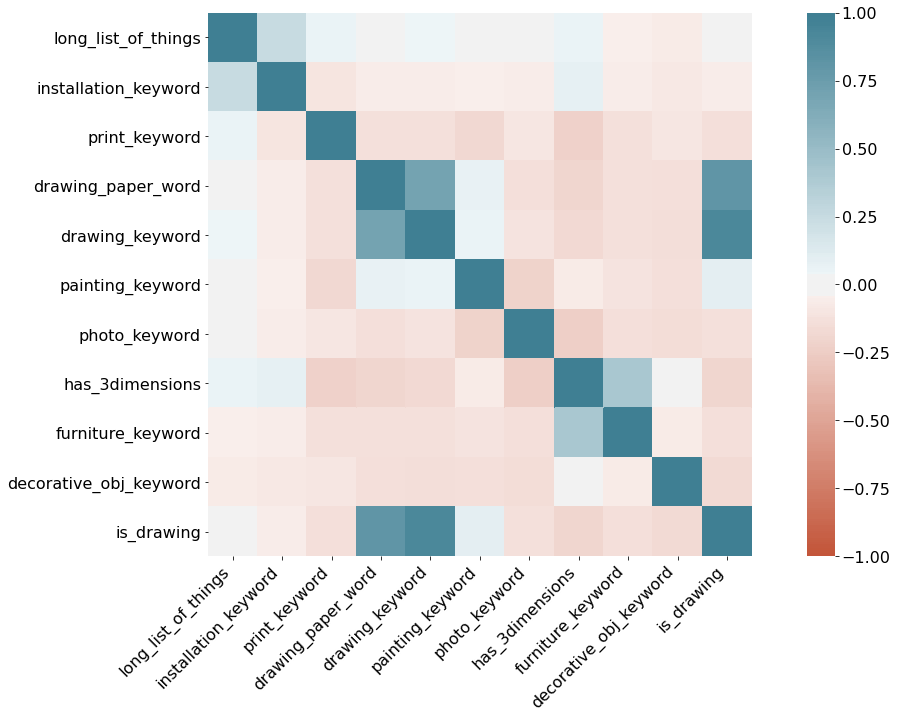

In [36]:
# Check correlations

corr = df_balanced_dataset_final[cols_to_use].corr()

plt.figure(figsize=(20,10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


In [37]:
## Save Augmented data
print(df_balanced_dataset_final.shape)

df_balanced_dataset_final.to_csv('./data/moma_baseline_model_balanced_dataset_05_11_2011.csv', index=False)

(5340, 43)


In [38]:
#Create labels & Training data 

y = pd.get_dummies(df_balanced_dataset_final['Classification'])

X = df_balanced_dataset_final[cols_to_use]

In [39]:
y.sample(10)

,Drawing,Installation,Painting,Photograph,Print,Sculpture,decorative_object,furniture
17473,0,0,0,1,0,0,0,0
48831,1,0,0,0,0,0,0,0
16282,0,0,0,1,0,0,0,0
40116,1,0,0,0,0,0,0,0
27448,0,0,0,0,1,0,0,0
40050,0,0,0,0,1,0,0,0
33490,0,0,1,0,0,0,0,0
33946,0,0,1,0,0,0,0,0
28610,0,0,0,0,1,0,0,0
40392,0,0,0,1,0,0,0,0


In [40]:
X.sample(10)

,long_list_of_things,installation_keyword,print_keyword,drawing_paper_word,drawing_keyword,painting_keyword,photo_keyword,has_3dimensions,furniture_keyword,decorative_obj_keyword,is_drawing
45636,False,False,False,False,False,False,False,False,False,False,False
35135,False,False,False,False,False,False,False,True,False,False,False
25230,False,False,True,False,False,False,False,False,False,False,False
41850,False,False,False,False,False,False,False,False,False,False,False
13385,False,False,False,False,False,False,True,False,False,False,False
50892,False,False,False,False,False,False,False,True,False,True,False
57410,False,False,False,False,False,False,False,False,False,False,False
1566,False,False,False,False,False,False,False,True,True,False,False
34779,False,False,False,False,False,False,False,True,False,False,False
31090,False,False,True,False,False,False,False,False,False,False,False


In [41]:
# Create an experiment

experiment = Experiment(api_key=auth.comet_api_key,
                         project_name="artwork-classification", workspace="lazell")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/lazell/artwork-classification/6c4a6edebff04921b50a7819752fa9a3



In [42]:
# Segragate Data into test, train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=88)


In [43]:
# Manual Logic Predictor

def if_then_classifier(y_test):

    y_pred_manual = np.array([y_test.columns])

    for index, row in X_test.iterrows():
        if row['print_keyword']:
            result= [0,0,0,0,1,0,0,0]
        elif row['photo_keyword']:
            result= [0,0,0,1,0,0,0,0]
        elif row['decorative_obj_keyword']:
            result= [0,0,0,0,0,0,1,0]
        elif row['furniture_keyword']:
            result= [0,0,0,0,0,0,0,1]
        elif row['is_drawing'].any():
            result= [1,0,0,0,0,0,0,0]
        elif row['has_3dimensions']:
            if row['installation_keyword']:
                result = [0,1,0,0,0,0,0,0]
                if row['long_list_of_things']:
                    result = [0,1,0,0,0,0,0,0]
            else:
                result = [0,0,0,0,0,1,0,0]
        elif row['painting_keyword']:
            result = [0,0,1,0,0,0,0,0]
        else:
            result = [0,0,0,0,0,0,0,0]
        y_pred_manual = np.vstack((y_pred_manual, result))
        
    y_pred_manual_final = pd.DataFrame(y_pred_manual[1:,]
                                   , columns=y_test.columns
                                   , index=X_test.index).astype('int')
    return y_pred_manual_final
    

In [44]:
y_pred_manual_final = if_then_classifier(y_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred_manual_final)
print(accuracy)

experiment.add_tag('Baseline Model')
experiment.log_metric("accuracy", accuracy)

0.8117977528089888


In [47]:
report = classification_report(y_test, y_pred_manual_final, target_names=y_test.columns)
print(report)

                   precision    recall  f1-score   support

          Drawing       0.87      0.91      0.89       306
     Installation       0.42      0.10      0.16       150
         Painting       0.92      0.79      0.85       316
       Photograph       0.93      0.92      0.92       293
            Print       0.94      0.91      0.92       264
        Sculpture       0.80      0.71      0.75       295
decorative_object       0.95      0.88      0.91       310
        furniture       0.94      0.99      0.96       202

        micro avg       0.90      0.81      0.85      2136
        macro avg       0.85      0.78      0.80      2136
     weighted avg       0.87      0.81      0.83      2136
      samples avg       0.81      0.81      0.81      2136



In [49]:
experiment.log_metric("f1-score micro", 0.85)
experiment.log_metric("f1-score macro", 0.80)
experiment.log_metric("f1-score weighted", 0.83)

experiment.log_metric("precision micro", 0.90)
experiment.log_metric("precision macro", 0.85)
experiment.log_metric("precision weighted", 0.87)

experiment.log_metric("recall micro", 0.81)
experiment.log_metric("recall macro", 0.78)
experiment.log_metric("recall weighted", 0.81)

In [50]:
experiment.add_tag('Notebook: Baseline Model - Heuristic Model')
experiment.end

COMET WARNING: Failed to add tag(s) Notebook: Baseline Model - Heuristic Model to the experiment



<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x12039c5b0>>

The manual classifier is very good, but doesn't do quite so well on installations and drawings compaged to the decision tree classifer. 
Overall accuracy is very good for both. The goal is to get to 95% overall accuracy for customers to trust the classification. 